# Instalação das bibliotecas

In [1]:
!pip install pandapower scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


# Bloco 2 - Imports

In [2]:
import numpy as np
import pandas as pd
import pandapower.networks as pn
import pandapower as pp
from sklearn.preprocessing import MinMaxScaler
import random

# Bloco 3 - função de geração dos cenários

In [3]:
import tensorflow as tf
print("GPU disponível?", tf.config.list_physical_devices('GPU'))

GPU disponível? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
# 1. Bibliotecas
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import random

# 2. Função de rede base (IEEE 57)
def criar_net_base():
    return pn.case57()

# 3. Configuração FV - Exemplo: 5 barras selecionadas (escolha estratégica)
configuracao_fotovoltaica = {
    10: {'p_mw_min': 0, 'p_mw_max': 40},
    15: {'p_mw_min': 0, 'p_mw_max': 35},
    32: {'p_mw_min': 0, 'p_mw_max': 30},
    40: {'p_mw_min': 0, 'p_mw_max': 25},
    50: {'p_mw_min': 0, 'p_mw_max': 30},
}

# 4. Geração de cenários ajustada para 57 barras
def adicionar_geracao_fv(net, pv_config):
    pv_data = {}
    # Simule um PERÍODO do dia (perfil + ruído)
    hora_dia = np.random.uniform(6, 18)
    fracao_irrad = max(0, np.sin(np.pi * (hora_dia-6)/12))
    for bus_idx, pv_params in pv_config.items():
        pico = pv_params['p_mw_max']
        variacao = np.random.uniform(0.90, 1.1)
        p_mw_atual = pico * fracao_irrad * variacao
        q_mvar_atual = 0  # (pode parametrizar depois c/ controle)
        pp.create_sgen(net, bus=bus_idx, p_mw=p_mw_atual, q_mvar=q_mvar_atual, name=f"PV_{bus_idx}")
        pv_data[f'p_pv_{bus_idx}_mw'] = p_mw_atual
    return net, pv_data

def variar_cargas_convencionais(net, p_loads_base, q_loads_base):
    n_loads = len(net.load)
    # Variabilidade razoável com componente global e ruído local
    fator_global = np.random.uniform(0.85, 1.15)
    ruido = np.random.normal(1.0, 0.035, size=n_loads)
    scale_p = fator_global * ruido
    scale_q = fator_global * ruido
    net.load.p_mw = p_loads_base * scale_p
    net.load.q_mvar = q_loads_base * scale_q
    return net

def variar_geracao_convencional(net, p_gen_base, q_gen_base):
    # Se possível, despachar proporcional à potência base para fechar o balanço
    # EXCLUIR o slack (primeiro gerador normalmente)
    gens = net.gen.index
    p_load_total = net.load.p_mw.sum()
    p_sgen_total = net.sgen.p_mw.sum() if len(net.sgen) > 0 else 0
    p_conv_desejada = p_load_total - p_sgen_total
    participacoes = p_gen_base / np.sum(p_gen_base)
    net.gen['p_mw'] = participacoes * p_conv_desejada
    # Variação leve de Qgen
    scale_q = np.random.uniform(0.85, 1.15, size=len(gens))
    net.gen['q_mvar'] = q_gen_base * scale_q
    return net

def aplicar_contingencias_linhas(net, n_lines, prob_cont=0.15, max_cont=2):
    status_linhas = np.ones(n_lines, dtype=int)
    if random.random() < prob_cont:
        num_desligar = random.randint(1, max_cont)
        linhas_desligar = random.sample(range(n_lines), k=num_desligar)
        for idx in linhas_desligar:
            net.line.loc[idx, 'in_service'] = False
            status_linhas[idx] = 0
    return net, status_linhas

def extrair_features(net, status_linhas, pv_data):
    X = []
    X.extend(net.load.p_mw.values)
    X.extend(net.load.q_mvar.values)
    X.extend(net.gen.p_mw.values)
    X.extend(net.gen.q_mvar.values)
    pv_keys_sorted = sorted(pv_data.keys())
    for key in pv_keys_sorted:
        X.append(pv_data[key])
    X.extend(status_linhas)
    return X

def gerar_nomes_features(n_loads, n_gens, n_lines, pv_config):
    nomes_X = []
    for i in range(n_loads):
        nomes_X.append(f'p_load_{i+1}_mw')
        nomes_X.append(f'q_load_{i+1}_mvar')
    for i in range(n_gens):
        nomes_X.append(f'p_gen_{i+1}_mw')
        nomes_X.append(f'q_gen_{i+1}_mvar')
    pv_keys_sorted = sorted([f'p_pv_{bus_idx}_mw' for bus_idx in pv_config.keys()])
    nomes_X.extend(pv_keys_sorted)
    for i in range(n_lines):
        nomes_X.append(f'line_{i+1}_inservice')
    return nomes_X

# Função geral que gera cenários
def gerar_cenarios_com_fv(num_cenarios=800, lotes=4, pv_config=None):
    if pv_config is None:
        pv_config = {}
    casos_por_lote = num_cenarios // lotes
    net_base = criar_net_base()
    # Após criar net (ou net_base), garanta que q_mvar existe em net.gen:
    if 'q_mvar' not in net_base.gen.columns:
     net_base.gen['q_mvar'] = 0.0

    p_loads_base = net_base.load.p_mw.values.copy()
    q_loads_base = net_base.load.q_mvar.values.copy()
    p_gen_base = net_base.gen.p_mw.values.copy()
    q_gen_base = net_base.gen.q_mvar.values.copy()
    n_gens = len(net_base.gen)
    n_loads = len(net_base.load)
    n_lines = len(net_base.line)
    n_barras = len(net_base.bus)
    nomes_X = gerar_nomes_features(n_loads, n_gens, n_lines, pv_config)
    nomes_y = [f'V_{i+1}_pu' for i in range(n_barras)]
    all_X, all_y = [], []
    for lote_idx in range(lotes):
        X_lote, y_lote = [], []
        for k in range(casos_por_lote):
            net = criar_net_base()
            # Após criar net (ou net_base), garanta que q_mvar existe em net.gen:
            if 'q_mvar' not in net.gen.columns:
              net.gen['q_mvar'] = 0.0
            net, pv_data_atual = adicionar_geracao_fv(net, pv_config)
            net = variar_cargas_convencionais(net, p_loads_base, q_loads_base)
            net = variar_geracao_convencional(net, p_gen_base, q_gen_base)
            net, status_linhas_atual = aplicar_contingencias_linhas(net, n_lines)
            try:
                pp.runpp(net, algorithm='nr')
                tensoes = net.res_bus.vm_pu.values.copy()
                if np.isnan(tensoes).any():
                    continue
                X = extrair_features(net, status_linhas_atual, pv_data_atual)
                X_lote.append(X)
                y_lote.append(tensoes.tolist())
            except pp.LoadflowNotConverged:
                continue
        if X_lote:
            X_lote_np = np.array(X_lote)
            y_lote_np = np.array(y_lote)
            np.save(f'X_lote_{lote_idx}.npy', X_lote_np)
            np.save(f'y_lote_{lote_idx}.npy', y_lote_np)
            all_X.append(X_lote_np)
            all_y.append(y_lote_np)
    if not all_X:
        raise RuntimeError("Nenhum cenário válido gerado!")
    all_X_np = np.concatenate(all_X, axis=0)
    all_y_np = np.concatenate(all_y, axis=0)
    with open("nomes_X.txt", "w") as f:
        f.write(','.join(nomes_X))
    with open("nomes_y.txt", "w") as f:
        f.write(','.join(nomes_y))
    return all_X_np, all_y_np, nomes_X, nomes_y

# GERAÇÃO dos dados
X_data, y_data, feature_names, target_names = gerar_cenarios_com_fv(
    num_cenarios=800, lotes=4, pv_config=configuracao_fotovoltaica
)

print("Cenários gerados:", X_data.shape)
print("Targets gerados:", y_data.shape)

# ----------- PRÉ-PROCESSAMENTO E SPLIT, SEM LEAK! -----------
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scalers só

Cenários gerados: (787, 164)
Targets gerados: (787, 57)


# Verificações

In [52]:
import numpy as np

# Usando os dados gerados anteriormente (y_data contém as tensões)
# Certifique-se de que y_data foi gerado e está disponível neste ponto do código
# Ex: rodando a função gerar_cenarios_com_fv() antes deste bloco

if 'y_data' in locals() and y_data is not None:
    variancias = np.var(y_data, axis=0)
    print("Variâncias das tensões por barra:", variancias)

    # Define um limiar de variância para considerar uma barra "significativa"
    limiar_variancia = 1e-4

    # Seleciona os índices das barras (colunas em y_data) com variância maior que o limiar
    barras_com_variancia = np.where(variancias > limiar_variancia)[0]

    if barras_com_variancia.size > 0:
        print("Usando APENAS os índices das barras com variância significativa:", barras_com_variancia)

        # Filtra a saída (y_data) para manter apenas as colunas (barras) selecionadas
        y_filtrado = y_data[:, barras_com_variancia]
        print("Formato dos dados de saída (y) após filtrar:", y_filtrado.shape)


        # Salva os índices das barras usadas para referência futura
        try:
            np.save("barras_usadas.npy", barras_com_variancia)
            print("Índices das barras usadas salvos em 'barras_usadas.npy'")
        except IOError as e:
            print(f"Erro ao salvar 'barras_usadas.npy': {e}")

    else:
        print(f"Nenhuma barra encontrada com variância maior que o limiar ({limiar_variancia}). Nenhum filtro aplicado.")
        y_filtrado = y_data # Manter todos os dados se nenhuma barra for filtrada
        print("Formato dos dados de saída (y) sem filtro:", y_filtrado.shape)


else:
    print("Erro: A variável 'y_data' não foi encontrada ou está vazia. Certifique-se de rodar a função de geração de cenários primeiro.")

# Agora você pode usar 'y_filtrado' para o treinamento do seu modelo
# y_filtrado contém as tensões APENAS para as barras selecionadas.

Variâncias das tensões por barra: [6.38977333e-29 5.37915806e-29 1.27526206e-28 3.20033837e-06
 3.22039312e-06 1.12980941e-28 1.22724960e-05 1.42850732e-29
 1.12998843e-28 8.82915639e-06 2.00071186e-05 1.28470622e-28
 1.08086154e-05 1.68101429e-05 7.00370217e-06 3.00346223e-06
 1.56046120e-06 2.40564774e-05 9.10101148e-05 1.26415058e-04
 1.29454095e-04 1.34278955e-04 1.68872852e-04 3.21801049e-04
 6.01468881e-04 3.51829370e-04 3.48605607e-04 2.66914838e-04
 2.35260745e-05 7.14923914e-04 8.93871706e-04 8.92194013e-04
 1.05367950e-03 6.02750184e-04 4.81657932e-04 3.86640786e-04
 2.68606506e-04 1.08339853e-04 2.71697401e-04 3.85089174e-04
 1.01571617e-04 2.64082843e-04 3.51635034e-05 1.02979366e-04
 2.37211967e-05 2.77440119e-05 6.68029355e-05 7.59171220e-05
 5.30053308e-05 7.57117057e-05 1.33523407e-05 1.77020787e-04
 2.61200061e-04 1.05490463e-04 7.30630425e-06 2.59846349e-04
 2.92066427e-04]
Usando APENAS os índices das barras com variância significativa: [19 20 21 22 23 24 25 26 27 29

In [53]:
import numpy as np

X = np.load('X_lote_0.npy')
y = np.load('y_lote_0.npy')

print(X.shape)
print(y.shape)
print("Amostra X:", X[0])
print("Amostra y:", y[0])
print("Valores máximos X:", X.max(axis=0))
print("Valores mínimos X:", X.min(axis=0))

(196, 164)
(196, 57)
Amostra X: [4.68295769e+01 2.68807334e+00 3.43901229e+01 1.11795037e+01
 6.24431266e+01 1.29519128e+02 9.99099465e+01 4.19938130e+00
 3.40302170e+02 1.48196327e+01 9.50404988e+00 1.88610803e+01
 3.62652215e+01 3.50356750e+01 2.22650097e+01 2.81276634e+00
 1.99603935e+00 5.16437100e+00 5.47963466e+00 7.35783268e+00
 4.02108861e+00 1.43874422e+01 3.02976039e+00 4.86923639e+00
 1.42507735e+00 3.14460473e+00 5.27834311e+00 1.20170623e+01
 5.94066171e+00 5.79942216e+00 1.66924876e+00 9.96512143e+00
 2.64725799e+01 1.55417021e+01 1.70967785e+01 1.50445966e+01
 4.29912250e+00 1.72085993e+01 3.54716994e+00 5.97170206e+00
 6.16816600e+00 5.76205260e+00 1.44745965e+01 7.88501512e+01
 1.76144532e+01 3.43984728e+00 1.66515004e+00 1.89961388e+01
 2.14682530e+01 1.67975252e+00 2.16637986e+01 1.89361974e+00
 4.79728232e+00 4.28660916e+00 2.53013173e+00 6.67346190e+00
 8.02195202e+00 5.11412061e-01 8.67843198e-01 1.72145700e+00
 2.78330650e+00 3.95582402e-01 2.01054431e+00 2.20043

In [54]:
from sklearn.model_selection import train_test_split
import numpy as np

# Supondo que X e y já estejam definidos e com shape igual
# Ex: X.shape = (499, n_entradas), y.shape = (499, 2) — tensões nas barras 13 e 14

# 70% treino, 15% validação, 15% teste
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 ≈ 15% de 85%

# Agora sim: filtros para remover linhas com NaN ou Inf
ok_train = ~(
    np.isnan(y_train).any(axis=1) |
    np.isinf(y_train).any(axis=1)
)
X_train = X_train[ok_train]
y_train = y_train[ok_train]

ok_val = ~(
    np.isnan(y_val).any(axis=1) |
    np.isinf(y_val).any(axis=1)
)
X_val = X_val[ok_val]
y_val = y_val[ok_val]

ok_test = ~(
    np.isnan(y_test).any(axis=1) |
    np.isinf(y_test).any(axis=1)
)
X_test = X_test[ok_test]
y_test = y_test[ok_test]


In [55]:
import numpy as np

print("Há NaNs em X_train?", np.isnan(X_train).any())
print("Há NaNs em y_train?", np.isnan(y_train).any())
print("Há Infs em X_train?", np.isinf(X_train).any())
print("Há Infs em y_train?", np.isinf(y_train).any())

print("Min X_train: ", np.nanmin(X_train), "Max X_train: ", np.nanmax(X_train))
print("Min y_train: ", np.nanmin(y_train), "Max y_train: ", np.nanmax(y_train))

Há NaNs em X_train? False
Há NaNs em y_train? False
Há Infs em X_train? False
Há Infs em y_train? False
Min X_train:  0.0 Max X_train:  791.940887223149
Min y_train:  0.6589191669611899 Max y_train:  1.04


In [56]:
print('y_train.shape:', y_train.shape)
print('y_train min:', np.nanmin(y_train), 'max:', np.nanmax(y_train))
print('y_train mean:', np.nanmean(y_train), 'std:', np.nanstd(y_train))
print('y_train sample:', y_train[:10])

y_train.shape: (136, 57)
y_train min: 0.6589191669611899 max: 1.04
y_train mean: 0.8976838719885263 std: 0.07607658455872611
y_train sample: [[1.04       1.01       0.985      0.97682615 0.97408975 0.98
  0.97535335 1.005      0.98       0.98266019 0.97343963 1.015
  0.98023905 0.97228667 0.98304914 1.018098   1.01920292 0.93204115
  0.88909227 0.87743257 0.83243334 0.83317187 0.83111866 0.81745161
  0.75906388 0.85277086 0.88900224 0.91094534 0.93033073 0.73448957
  0.70713384 0.75372304 0.75953158 0.81433119 0.81525345 0.82112763
  0.82482441 0.83736473 0.82372112 0.82148836 0.87917717 0.81739389
  0.9173951  0.8567069  0.91089073 0.86342786 0.84146296 0.84082986
  0.8464643  0.83915209 0.90310123 0.87786603 0.85860425 0.87841961
  0.91071256 0.79709935 0.78129258]
 [1.04       1.01       0.985      0.980258   0.97665737 0.98
  0.98203696 1.005      0.98       0.98610979 0.97638004 1.015
  0.98710086 0.98200343 0.98921734 1.01847612 1.0232312  0.95044853
  0.91491941 0.90346261 0.858

In [57]:
print('N linhas all-zero:', np.sum(np.all(y_train == 0, axis=1)))
print('N linhas all-one:', np.sum(np.all(y_train == 1, axis=1)))

N linhas all-zero: 0
N linhas all-one: 0


In [58]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# --------- 1. Carregar todos os lotes juntos -----------
num_lotes = 4  # Ajuste ao seu caso
X_all, y_all = [], []
for i in range(num_lotes):
    try:
        X_lote = np.load(f'X_lote_{i}.npy')
        y_lote = np.load(f'y_lote_{i}.npy')
        X_all.append(X_lote)
        y_all.append(y_lote)
    except FileNotFoundError:
        print(f"Lote {i} não encontrado, pulando.")
if not X_all:
    raise ValueError("Nenhum dado encontrado.")

X_all = np.vstack(X_all)
y_all = np.vstack(y_all)

print("Shapes completos:", X_all.shape, y_all.shape)

# --------- 2. NÃO FILTRAR tensões por variância, usar todas -------
# (Opcional) Salvar nomes das features/alvos
with open("nomes_X.txt", "w") as f:
    for i in range(X_all.shape[1]): f.write(f"X_{i},")
with open("nomes_y.txt", "w") as f:
    for i in range(y_all.shape[1]): f.write(f"V_{i+1}_pu,")

# --------- 3. Split - dividir ANTES da normalização! ---------------
# 70% treino, 15% val, 15% teste
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# --------- 4. Normalização (apenas scalers treinados NO TREINO) -----------
scaler_X = MinMaxScaler()
X_train_norm = scaler_X.fit_transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)
joblib.dump(scaler_X, "scaler_X.save")

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)
joblib.dump(scaler_y, "scaler_y.save")

print("Treino, val, test shapes:", X_train_norm.shape, y_train_norm.shape, X_val_norm.shape, X_test_norm.shape)

# --------- 5. Garantir limpeza de NaN/inf (em tudo) -----------------
for nome, array in zip(
    ["train", "val", "test"],
    [(X_train_norm, y_train_norm), (X_val_norm, y_val_norm), (X_test_norm, y_test_norm)]
):
    Xf, yf = array
    mask = ~(np.isnan(Xf).any(axis=1) | np.isinf(Xf).any(axis=1) |
             np.isnan(yf).any(axis=1) | np.isinf(yf).any(axis=1))
    print(f"Após limpeza, {nome}: {np.sum(mask)} amostras válidas.")
    if nome == "train":
        X_train_norm, y_train_norm = Xf[mask], yf[mask]
    elif nome == "val":
        X_val_norm, y_val_norm = Xf[mask], yf[mask]
    elif nome == "test":
        X_test_norm, y_test_norm = Xf[mask], yf[mask]

# --------- 6. Treinamento do modelo --------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# se desejar mudar arquitetura, altere aqui
model = keras.Sequential([
    layers.Input(shape=(X_train_norm.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train_norm.shape[1]),  # ajusta para qtd de barras (normalmente 14)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# callbacks essenciais
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('melhor_modelo.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_norm, y_train_norm,
    epochs=150, batch_size=32,
    validation_data=(X_val_norm, y_val_norm),
    callbacks=callbacks
)

# --------- 7. AVALIAÇÃO EM PU (escala física) ---------------
# Previsão conjunto de testes
y_pred_norm = model.predict(X_test_norm)
y_pred_test = scaler_y.inverse_transform(y_pred_norm)
y_true_test = scaler_y.inverse_transform(y_test_norm)

from sklearn.metrics import mean_absolute_error, mean_squared_error
for i in range(y_true_test.shape[1]):
    mae_i = mean_absolute_error(y_true_test[:, i], y_pred_test[:, i])
    mse_i = mean_squared_error(y_true_test[:, i], y_pred_test[:, i])
    rmse_i = np.sqrt(mse_i)
    print(f"Barra {i+1}: MAE={mae_i:.5f} | RMSE={rmse_i:.5f}")

for i in range(y_true_test.shape[1]):
    mae_i = mean_absolute_error(y_true_test[:, i], y_pred_test[:, i])
    mse_i = mean_squared_error(y_true_test[:, i], y_pred_test[:, i])
    rmse_i = np.sqrt(mse_i)
    print(f"Barra {i+1}: MAE={mae_i:.5f} | RMSE={rmse_i:.5f}")
# --------- 8. Salve os conjuntos finais para outros usos -----------
np.save('X_train_norm.npy', X_train_norm)
np.save('y_train_norm.npy', y_train_norm)
np.save('X_val_norm.npy', X_val_norm)
np.save('y_val_norm.npy', y_val_norm)
np.save('X_test_norm.npy', X_test_norm)
np.save('y_test_norm.npy', y_test_norm)

Shapes completos: (787, 164) (787, 57)
Treino, val, test shapes: (550, 164) (550, 57) (118, 164) (119, 164)
Após limpeza, train: 550 amostras válidas.
Após limpeza, val: 118 amostras válidas.
Após limpeza, test: 119 amostras válidas.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 57)             │         7,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,985 (175.72 KB)

 Trainable params: 44,985 (175.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.3975 - mae: 0.5135 - val_loss: 0.0447 - val_mae: 0.1656
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 - mae: 0.1348 - val_loss: 0.0130 - val_mae: 0.0813
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mae: 0.0738 - val_loss: 0.0079 - val_mae: 0.0561
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0543 - val_loss: 0.0069 - val_mae: 0.0498
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mae: 0.0495 - val_loss: 0.0068 - val_mae: 0.0475
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mae: 0.0448 - val_loss: 0.0063 - val_mae: 0.0445
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0417 - val_loss: 0.0063 - val_mae: 0.0437
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mae: 0.0423 - val_loss: 0.0059 - val_mae: 0.0424
Epoch 9/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib

In [60]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [61]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train.shape[1])   # <--- Ajusta para o novo numero de barras (normalmente 11 para caso14)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 57)             │         7,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,985 (175.72 KB)

 Trainable params: 44,985 (175.72 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 836.2307 - mae: 20.6388 - val_loss: 42.4170 - val_mae: 5.1766
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.9668 - mae: 3.9312 - val_loss: 7.0544 - val_mae: 2.0994
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0122 - mae: 1.7661 - val_loss: 1.6202 - val_mae: 0.9886
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3729 - mae: 0.9063 - val_loss: 0.8567 - val_mae: 0.6898
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8281 - mae: 0.6869 - val_loss: 0.6852 - val_mae: 0.6166
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6698 - mae: 0.6152 - val_loss: 0.5945 - val_mae: 0.5753
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6061 - mae: 0.5865 - val_loss: 0.5368 - val_mae: 0.5472
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5592 - mae: 0.5634 - val_loss: 0.5104 - val_mae: 0.5380
Epoch 9/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


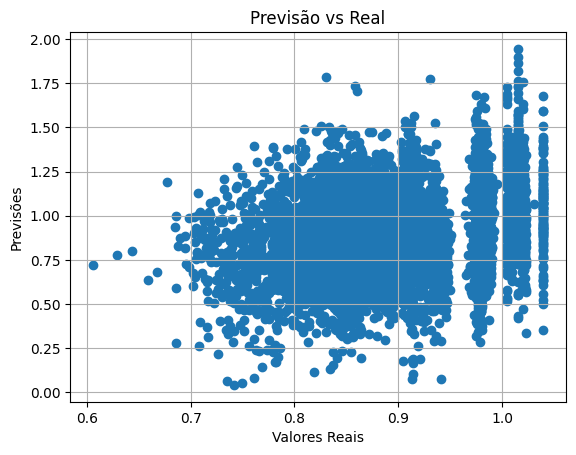

In [63]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)
plt.scatter(y_val, y_pred)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Previsão vs Real")
plt.grid(True)
plt.show()


In [64]:
# Importe as bibliotecas necessárias (se ainda não estiverem importadas)
# Certifique-se de que você importou essas classes:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # Já estava importado, mas é bom garantir

# Assuma que o objeto 'model' já está definido e foi treinado por 150 épocas.
# Assuma que X_train, y_train, X_val, y_val estão disponíveis.
# Você precisará saber o batch_size usado anteriormente.

print(f"Continuando o treinamento do modelo a partir da época {150+1}...")

# Defina o número total de épocas que você deseja atingir
total_epochs_desejado = 250 # Por exemplo, para treinar por mais 100 épocas (150 + 100)

# --- DEFINIÇÃO DOS CALLBACKS (DESCOMENTE E AJUSTE) ---
# Crie a lista de callbacks que você deseja usar durante a continuação
callbacks_list = [
    # EarlyStopping: Para parar o treinamento se a val_loss não melhorar por 'patience' épocas
    # restore_best_weights=True: Para que, ao parar, o modelo volte aos pesos da melhor época
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    # ModelCheckpoint: Para salvar os pesos do modelo (ou o modelo inteiro) na melhor época
    # monitor='val_loss': Monitora a perda no conjunto de validação
    # save_best_only=True: Salva apenas a versão do modelo que teve a melhor val_loss até o momento
    # 'melhor_modelo_continuacao.keras': Nome do arquivo onde o modelo será salvo.
    ModelCheckpoint('melhor_modelo_continuacao.keras', monitor='val_loss', save_best_only=True)
]
# --- FIM DA DEFINIÇÃO DOS CALLBACKS ---


# Chame o método fit novamente para continuar o treinamento
history_continued = model.fit(
    X_train,
    y_train,
    epochs=total_epochs_desejado,  # O número TOTAL de épocas a serem atingidas (ex: 250)
    initial_epoch=150,          # A época inicial para esta chamada fit (onde a anterior parou)
    batch_size=32, # <--- SUBSTITUA 32 PELO SEU VALOR DE batch_size ANTERIOR
    validation_data=(X_val, y_val),
    callbacks=callbacks_list # Use a lista de callbacks definida
)

print("\nTreinamento continuado concluído.")

# O histórico do treinamento continuado está em history_continued
# Você pode opcionalmente combinar os históricos se salvou o anterior
# Ex: combined_history = history_original + history_continued

# Se o ModelCheckpoint salvou um modelo, você pode carregá-lo depois
# from tensorflow.keras.models import load_model
# best_model = load_model('melhor_modelo_continuacao.keras')

Continuando o treinamento do modelo a partir da época 151...
Epoch 151/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0562 - mae: 0.1872 - val_loss: 0.0970 - val_mae: 0.2486
Epoch 152/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0689 - mae: 0.2081 - val_loss: 0.0575 - val_mae: 0.1889
Epoch 153/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0545 - mae: 0.1851 - val_loss: 0.0570 - val_mae: 0.1890
Epoch 154/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0526 - mae: 0.1813 - val_loss: 0.0632 - val_mae: 0.1990
Epoch 155/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0581 - mae: 0.1908 - val_loss: 0.0595 - val_mae: 0.1918
Epoch 156/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0541 - mae: 0.1840 - val_loss: 0.0638 - val_mae: 0.2007
Epoch 157/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0570 - mae: 0.1881 - val_loss: 0.0592 - val_mae: 0.1931
Epoch 158/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0545 - mae: 0.1852 - val_loss: 0.0620 - val

In [65]:
# Importe as bibliotecas necessárias
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error # Opcional: para calcular métricas na escala original

# Assuma que X_test e y_test estão disponíveis após a etapa de split e filtragem
# Assuma que os scalers foram salvos como 'scaler_X.save' e 'scaler_y.save'
# Assuma que o melhor modelo foi salvo como 'melhor_modelo_continuacao.keras'

# --- 1. Carregar o melhor modelo salvo ---
try:
    modelo_final = load_model('melhor_modelo_continuacao.keras')
    print("Modelo salvo carregado com sucesso.")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    modelo_final = None # Define como None para evitar erros posteriores se o carregamento falhar

# --- 2. Carregar os scalers salvos ---
try:
    scaler_X = joblib.load("scaler_X.save")
    scaler_y = joblib.load("scaler_y.save")
    print("Scalers carregados com sucesso.")
except FileNotFoundError as e:
    print(f"Erro ao carregar scalers: {e}. Certifique-se de que 'scaler_X.save' e 'scaler_y.save' existem.")
    scaler_X, scaler_y = None, None # Define como None para evitar erros posteriores

# Certifique-se de que o modelo e os scalers foram carregados antes de prosseguir
if modelo_final is not None and scaler_X is not None and scaler_y is not None:

    # --- 3. Avaliar o modelo no conjunto de teste (na escala normalizada) ---
    print("\nAvaliando o modelo no conjunto de teste (escala normalizada)...")
    # O método evaluate retorna a perda e quaisquer métricas adicionais compiladas (como MAE)
    resultados_avaliacao = modelo_final.evaluate(X_test, y_test, verbose=0)

    # Verifica os nomes das métricas compiladas no modelo para imprimi-las corretamente
    metric_names = modelo_final.metrics_names
    print("Resultados da avaliação no Teste (Normalizado):")
    for name, value in zip(metric_names, resultados_avaliacao):
        print(f"  {name}: {value:.6f}")


    # --- 4. Fazer previsões no conjunto de teste ---
    print("\nFazendo previsões no conjunto de teste...")
    y_pred_norm = modelo_final.predict(X_test)
    print(f"Previsões normalizadas geradas. Formato: {y_pred_norm.shape}")


    # --- 5. Desnormalizar as previsões e os valores reais do teste ---
    print("\nDesnormalizando previsões e valores reais...")

    # Desnormaliza as previsões do modelo
    y_pred_original_scale = scaler_y.inverse_transform(y_pred_norm)

    # Desnormaliza os valores reais do conjunto de teste
    y_test_original_scale = scaler_y.inverse_transform(y_test)

    print(f"Previsões desnormalizadas. Formato: {y_pred_original_scale.shape}")
    print(f"Valores reais do teste desnormalizados. Formato: {y_test_original_scale.shape}")


    # --- 6. Analisar resultados na escala original (Opcional) ---
    print("\nAnálise na escala original (p.u.):")

    # Calcule métricas na escala original
    mae_original = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
    mse_original = mean_squared_error(y_test_original_scale, y_pred_original_scale)
    rmse_original = np.sqrt(mse_original) # RMSE é a raiz quadrada do MSE

    print(f"Mean Absolute Error (MAE) na escala original: {mae_original:.6f}")
    print(f"Mean Squared Error (MSE) na escala original: {mse_original:.6f}")
    print(f"Root Mean Squared Error (RMSE) na escala original: {rmse_original:.6f}")


    # Mostra um exemplo de previsões vs. valores reais para algumas amostras e barras
    print("\nExemplo de Previsões vs. Real (Primeiras 5 amostras, primeiras 3 barras):")
    num_amostras_exemplo = min(5, y_test_original_scale.shape[0])
    num_barras_exemplo = min(3, y_test_original_scale.shape[1]) # Usa o número de barras que foram mantidas

    # Se você salvou 'barras_usadas.npy', pode carregar para saber quais barras são
    try:
        barras_usadas_indices = np.load("barras_usadas.npy")
        print(f"(Barra Original Índice: {barras_usadas_indices[:num_barras_exemplo]})")
    except FileNotFoundError:
         print("(Índices das barras usadas não encontrados. Mostrando apenas as primeiras colunas.)")
         barras_usadas_indices = np.arange(y_test_original_scale.shape[1]) # Assume que são as primeiras colunas se o arquivo não existe


    for i in range(num_amostras_exemplo):
        print(f"Amostra {i+1}:")
        for j in range(num_barras_exemplo):
             # Usa o índice original da barra se disponível
             original_bus_index = barras_usadas_indices[j] if 'barras_usadas_indices' in locals() else j
             print(f"  Barra (original idx {original_bus_index}): Real = {y_test_original_scale[i, j]:.4f} p.u., Previsto = {y_pred_original_scale[i, j]:.4f} p.u.")


else:
    print("\nNão foi possível prosseguir com avaliação e previsão devido a erros no carregamento do modelo ou scalers.")

Modelo salvo carregado com sucesso.
Scalers carregados com sucesso.

Avaliando o modelo no conjunto de teste (escala normalizada)...
Resultados da avaliação no Teste (Normalizado):
  loss: 0.044715
  compile_metrics: 0.166680

Fazendo previsões no conjunto de teste...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Previsões normalizadas geradas. Formato: (119, 57)

Desnormalizando previsões e valores reais...
Previsões desnormalizadas. Formato: (119, 57)
Valores reais do teste desnormalizados. Formato: (119, 57)

Análise na escala original (p.u.):
Mean Absolute Error (MAE) na escala original: 0.035491
Mean Squared Error (MSE) na escala original: 0.005752
Root Mean Squared Error (RMSE) na escala original: 0.075843

Exemplo de Previsões vs. Real (Primeiras 5 amostras, primeiras 3 barras):
(Barra Original Índice: [19 20 21])
Amostra 1:
  Barra (original idx 19): Real = 2.0800 p.u., Previsto = 2.0922 p.u.
  Barra (original idx 20): Real = 2.0200 p.u., Previsto = 2.1464 p.u.
  Barra (original idx 21

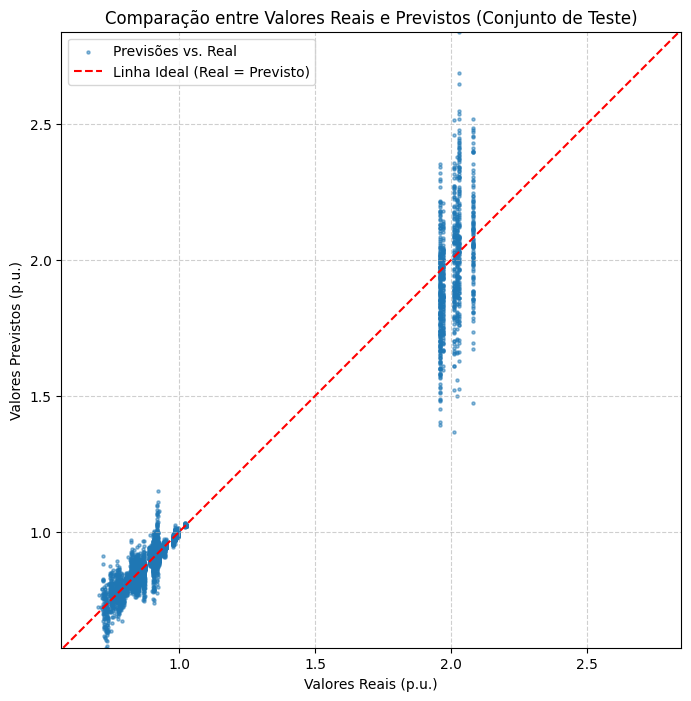

In [66]:
# Importar a biblioteca de plotagem
import matplotlib.pyplot as plt
import numpy as np # Já deve estar importado, mas para garantir

# --- Assumir que y_test_original_scale e y_pred_original_scale estão disponíveis ---
# Se você executou o código de avaliação e previsão na mesma sessão, eles estarão aqui.
# Caso contrário, você precisará carregar os dados de teste originais
# (ou os dados de teste normalizados e desnormalizar novamente)
# e carregar o modelo e o scaler para gerar y_pred_original_scale.

# Para o gráfico, é útil achatar (flatten) os arrays para ter uma lista única de todos os valores reais e previstos.
# Cada ponto no gráfico será uma tensão específica de uma barra específica em um cenário específico do conjunto de teste.
y_real_flat = y_test_original_scale.flatten()
y_previsto_flat = y_pred_original_scale.flatten()

# --- Criar o Gráfico de Dispersão ---
plt.figure(figsize=(8, 8)) # Define o tamanho da figura

# Cria o scatter plot (gráfico de dispersão)
plt.scatter(y_real_flat, y_previsto_flat, alpha=0.5, s=5, label='Previsões vs. Real') # alpha controla a transparência, s o tamanho do ponto

# Adiciona a linha de identidade (y=x) como referência.
# Se a previsão fosse perfeita, todos os pontos estariam nesta linha.
min_val = min(y_real_flat.min(), y_previsto_flat.min())
max_val = max(y_real_flat.max(), y_previsto_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Linha Ideal (Real = Previsto)') # 'r--' para linha vermelha tracejada

# Configurações do gráfico
plt.title('Comparação entre Valores Reais e Previstos (Conjunto de Teste)')
plt.xlabel('Valores Reais (p.u.)')
plt.ylabel('Valores Previstos (p.u.)')
plt.grid(True, linestyle='--', alpha=0.6) # Adiciona um grid
plt.axis('equal') # Garante que os eixos X e Y tenham a mesma escala, tornando a linha y=x visualmente correta
plt.legend() # Mostra a legenda
plt.xlim([min_val, max_val]) # Define os limites do eixo X baseados nos dados
plt.ylim([min_val, max_val]) # Define os limites do eixo Y baseados nos dados

# Mostrar o gráfico
plt.show()

Shape y_true_test: (119, 57)
Shape y_pred_test: (119, 57)
Valores reais (y_true_test): min = 0.637471926708161 max = 1.04
Valores previstos (y_pred_test): min = 0.6524603 max = 1.1267629
Previsões <0.90 pu: 3759 | Previsões >1.10 pu: 1


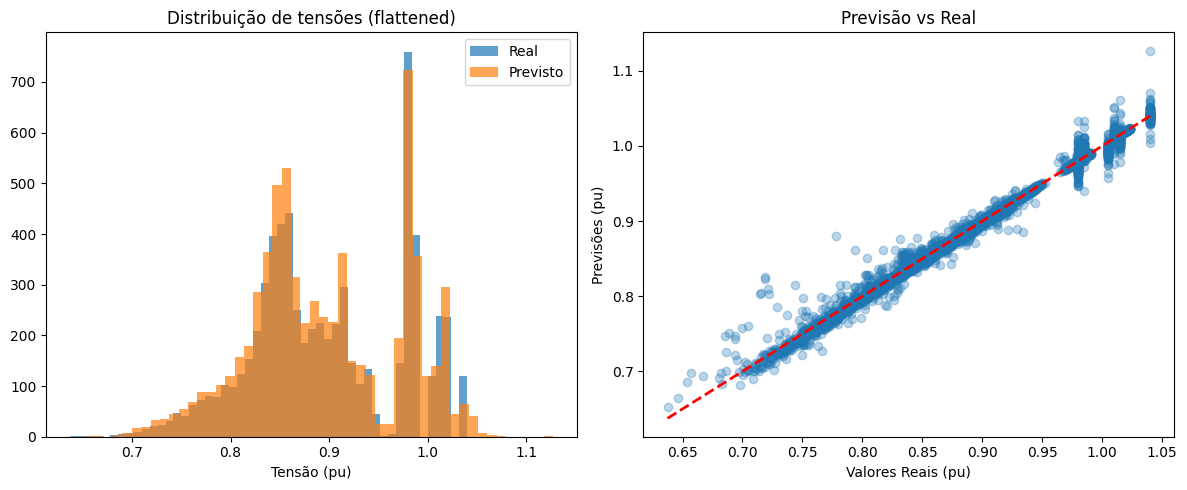


MAE total: 0.00332 pu | RMSE total: 0.00713 pu
Barra  1: MAE=0.00663 pu | RMSE=0.01179 pu | min real=1.040 max real=1.040
Barra  2: MAE=0.00693 pu | RMSE=0.01012 pu | min real=1.010 max real=1.010
Barra  3: MAE=0.00940 pu | RMSE=0.01265 pu | min real=0.985 max real=0.985
Barra  4: MAE=0.00039 pu | RMSE=0.00057 pu | min real=0.976 max real=0.980
Barra  5: MAE=0.00053 pu | RMSE=0.00075 pu | min real=0.968 max real=0.977
Barra  6: MAE=0.00686 pu | RMSE=0.00943 pu | min real=0.980 max real=0.980
Barra  7: MAE=0.00073 pu | RMSE=0.00119 pu | min real=0.969 max real=0.984
Barra  8: MAE=0.01194 pu | RMSE=0.01419 pu | min real=1.005 max real=1.005
Barra  9: MAE=0.01042 pu | RMSE=0.01403 pu | min real=0.980 max real=0.980
Barra 10: MAE=0.00054 pu | RMSE=0.00073 pu | min real=0.979 max real=0.991
Barra 11: MAE=0.00058 pu | RMSE=0.00156 pu | min real=0.965 max real=0.986
Barra 12: MAE=0.00790 pu | RMSE=0.01070 pu | min real=1.015 max real=1.015
Barra 13: MAE=0.00072 pu | RMSE=0.00263 pu | min rea

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Checagem básica de shapes e ranges
print("Shape y_true_test:", y_true_test.shape)
print("Shape y_pred_test:", y_pred_test.shape)
print("Valores reais (y_true_test): min =", np.min(y_true_test), "max =", np.max(y_true_test))
print("Valores previstos (y_pred_test): min =", np.min(y_pred_test), "max =", np.max(y_pred_test))

# 2. Outliers e valores absurdos em previsão
n_pred_muito_baixa = np.sum(y_pred_test < 0.90)  # típico para pu < 1.0
n_pred_muito_alta = np.sum(y_pred_test > 1.10)
print(f"Previsões <0.90 pu: {n_pred_muito_baixa} | Previsões >1.10 pu: {n_pred_muito_alta}")

# 3. Histogramas para distribuição dos valores
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_true_test.flatten(), bins=50, alpha=0.7, label="Real", color="tab:blue")
plt.hist(y_pred_test.flatten(), bins=50, alpha=0.7, label="Previsto", color="tab:orange")
plt.xlabel("Tensão (pu)")
plt.title("Distribuição de tensões (flattened)")
plt.legend()

# 4. Gráfico Previsão vs Real com linha de identidade
plt.subplot(1,2,2)
plt.scatter(y_true_test.flatten(), y_pred_test.flatten(), alpha=0.3)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reais (pu)")
plt.ylabel("Previsões (pu)")
plt.title('Previsão vs Real')
plt.tight_layout()
plt.show()

# 5. Métricas globais e por barra
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_total = mean_absolute_error(y_true_test, y_pred_test)
mse_total = mean_squared_error(y_true_test, y_pred_test)
rmse_total = np.sqrt(mse_total)
print(f"\nMAE total: {mae_total:.5f} pu | RMSE total: {rmse_total:.5f} pu")

for i in range(y_true_test.shape[1]):
    mae_i = mean_absolute_error(y_true_test[:, i], y_pred_test[:, i])
    mse_i = mean_squared_error(y_true_test[:, i], y_pred_test[:, i])
    rmse_i = np.sqrt(mse_i)
    print(f"Barra {i+1:2}: MAE={mae_i:.5f} pu | RMSE={rmse_i:.5f} pu | min real={y_true_test[:,i].min():.3f} max real={y_true_test[:,i].max():.3f}")

# 6. Detecção de tensões fora do range físico esperado (exemplo: pu < 0.9 ou pu > 1.1)
tensoes_invalidas_pred = np.sum((y_pred_test < 0.90) | (y_pred_test > 1.10))
tensoes_invalidas_real = np.sum((y_true_test < 0.90) | (y_true_test > 1.10))
print(f"\n# Tensões previstas fora de [0.9,1.1] pu: {tensoes_invalidas_pred}")
print(f"# Tensões reais fora de [0.9,1.1] pu: {tensoes_invalidas_real}")

# 7. Opcional: Tabela instantânea para os 10 primeiros exemplos
print("\nExemplo de comparação (primeiras 10 amostras):")
for i in range(min(10, y_true_test.shape[0])):
    print(f"Amostra {i+1}: real={np.round(y_true_test[i],3)}, prev={np.round(y_pred_test[i],3)}")
